In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('/data/Houston/LIGHTNING/6sensor_minimum/LYLOUT_220819_000000_86400_map500m.nc')

In [3]:
import cartopy.crs as ccrs

### WARNING ###
# The initial TRACER LMA processing was completed in late Nov 2022, with the following paramters.
# This might change in subsequent processing, so map visualizations will only be correct
# if this section is kept in sync.

sbu_earth = 6367.0e3

# This is KHGX.
lma_grid_ctr_lat, lma_grid_ctr_lon = 29.47190094, -95.07873535
    
#     dx = dy = 500.0
#     nx, ny = 1001, 1001
#     x = dx*(np.arange(nx, dtype='float') - nx/2) + dx/2
#     y = dy*(np.arange(ny, dtype='float') - ny/2) + dy/2
#     # x, y = np.meshgrid(x,y)
#     radar_map = proj4.crs.CRS(proj='aeqd', R=sbu_earth,
#                          lat_0=ctr_lat, lon_0=ctr_lon)
#     radar_lla = proj4.crs.CRS(proj='latlong', R=sbu_earth)
globe = ccrs.Globe(semimajor_axis=sbu_earth, semiminor_axis=sbu_earth)
crs = ccrs.AzimuthalEquidistant(central_longitude=lma_grid_ctr_lon,
                                central_latitude=lma_grid_ctr_lat,
                                globe=globe)

In [10]:
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom

from matplotlib.colors import LogNorm
fed_norm = LogNorm(vmin=1, vmax=400)

def range_ring(radius, crs):
    gd = Geodesic()
    cp = gd.circle(lon=crs.proj4_params['lon_0'],
                   lat=crs.proj4_params['lat_0'], radius=radius)
    return sgeom.Polygon(cp)

def plot_grid_map(grid, title=""):
    fig = plt.figure()

    
    p = grid.plot.imshow(norm=fed_norm, transform=crs, subplot_kws={"projection": crs})
    p.axes.coastlines()
    p.axes.set_title(title)

    geoms = [range_ring(r, crs) for r in [50e3, 100e3, 150e3, 200e3, 250e3]]
    p.axes.add_geometries(geoms, crs=ccrs.PlateCarree(), linewidth=0.5,
                          edgecolor='r', facecolor='none', alpha=0.5)

In [7]:
fed_sum = ds.flash_extent_density.sum(dim='grid_time')

/Users/ebruning/miniconda3/envs/lmatracer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


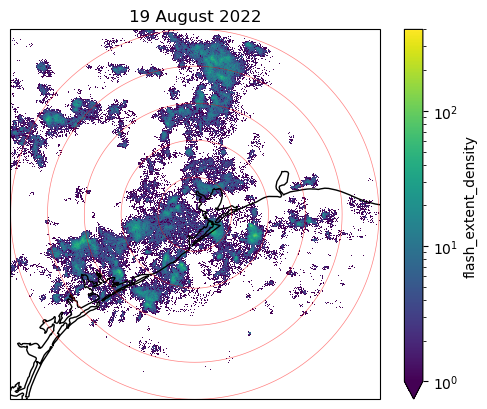

In [11]:
plot_grid_map(fed_sum, title="19 August 2022")

In [13]:
fed_out=fed_sum.to_dataset()

In [14]:
fed_out['longitude']=ds.lon
fed_out['latitude']=ds.lat

In [15]:
fed_out

<xarray.Dataset>
Dimensions:               (grid_x: 1001, grid_y: 1001)
Coordinates:
  * grid_x                (grid_x) float64 -2.5e+05 -2.495e+05 ... 2.5e+05
  * grid_y                (grid_y) float64 -2.5e+05 -2.495e+05 ... 2.5e+05
Data variables:
    flash_extent_density  (grid_y, grid_x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    longitude             (grid_y, grid_x) float64 ...
    latitude              (grid_y, grid_x) float64 ...

In [16]:
fed_out.to_netcdf('20220819_fed_daily_sum.nc')